# When does upwelling start and end..?
Using modelled and observed alongshore flow, the Bakun index, and 2022 SOPO report by Hourston and Thompson

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import xarray as xr
from scipy import stats
from matplotlib.gridspec import GridSpec


In [2]:
def calc_stats(x, y):
    stat = {}
    x_new = x[np.isfinite(x)]
    y_new = y[np.isfinite(x)]
    x = x_new[np.isfinite(y_new)]
    y = y_new[np.isfinite(y_new)]

    MSE = np.mean((y - x)**2)
    stat['RMSE'] = np.sqrt(MSE)
    stat['bias'] = np.mean(y) - np.mean(x)
    stat['WSS'] = 1 - MSE / np.mean((abs(y - np.mean(x)) + abs(x - np.mean(x)))**2)
    stat['r'] = stats.pearsonr(x,y).statistic
    
    return stat

def plot_panel(ax, x, y, lims, units):
    stats = calc_stats(x, y)

    statstext = f"RMSE = {stats['RMSE']:.3f} {units}\nbias = {stats['bias']:.3f} {units}\nWSS = {stats['WSS']:.3f}\nr = {stats['r']:.3f}"
    
    props = dict(boxstyle='round', facecolor='w', alpha=0.9)
    c = ax.text(0.02, 0.04, statstext, bbox=props, transform=ax.transAxes, fontsize=9)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    
    return c

### Observed and modelled flow along the Washington Shelf

In [3]:
df = pd.read_pickle("/data1/bbeutel/LO_output/extract_cast/ooi/ooi-ce07shsm_ns.p")

#change it to daily
df = df.set_index('datetime')
df = df.resample('D',axis=0).mean()
df['datetime'] = df.index
df['datetime'] = df.datetime.dt.tz_localize(None)
index = pd.Index(range(len(df)))
df.set_index(index,inplace=True)

# undo a conversion you did wrong while downloading
df['model_o'] = df['model_o']*1000
df['model_n'] = df['model_n']*1000

df.head()

/tmp/ipykernel_161916/586479787.py:5: FutureWarning: The 'axis' keyword in DataFrame.resample is deprecated and will be removed in a future version.
  df = df.resample('D',axis=0).mean()


,longitude (degrees_east),latitude (degrees_north),sea_water_pressure (decibars),sea_water_density (kg.m-3),sea_water_temperature (degree_Celsius),sea_water_practical_salinity (1e-3),eastward_sea_water_velocity (m.s-1),northward_sea_water_velocity (m.s-1),upward_sea_water_velocity (m.s-1),mole_concentration_of_dissolved_molecular_oxygen_in_sea_water (micromol.L-1),mole_concentration_of_nitrate_in_sea_water (micromol.L-1),mole_concentration_of_nitrate_in_sea_water_full (micromol.L-1),model_s,model_t,model_o,model_n,model_u,model_v,model_w,datetime
0,-124.56771,46.98805,6.854692,1022.847750,11.576610,30.034466,-0.117203,0.105899,-0.003214,328.064508,2.382661,NaN,32.049187,11.342179,292748.753139,3699.383514,0.060074,-0.150205,-0.000438,2015-04-05
1,-124.56771,46.98805,6.999410,1022.709479,11.855760,29.919234,-0.072239,0.012859,0.012250,327.080932,1.737885,NaN,32.043394,11.200430,303958.724976,2849.506820,0.007874,-0.154421,0.000132,2015-04-06
2,-124.56771,46.98805,6.984690,1022.692406,11.871754,29.900849,-0.005883,-0.068618,0.023058,328.092859,1.653027,NaN,31.978598,11.138652,305924.210866,3358.608812,0.022341,-0.101412,-0.000099,2015-04-07
3,-124.56771,46.98805,7.086526,1021.992800,11.894292,29.003054,0.002292,-0.023756,0.021859,332.698058,2.136899,NaN,31.927282,11.167915,311147.148132,2822.140145,-0.006459,-0.102180,-0.000057,2015-04-08
4,-124.56771,46.98805,7.166901,1023.409156,11.902085,30.830995,-0.010126,-0.118461,0.007072,325.987637,1.218262,NaN,31.980176,11.216674,316177.506765,2101.774228,-0.050276,-0.133598,0.000003,2015-04-09


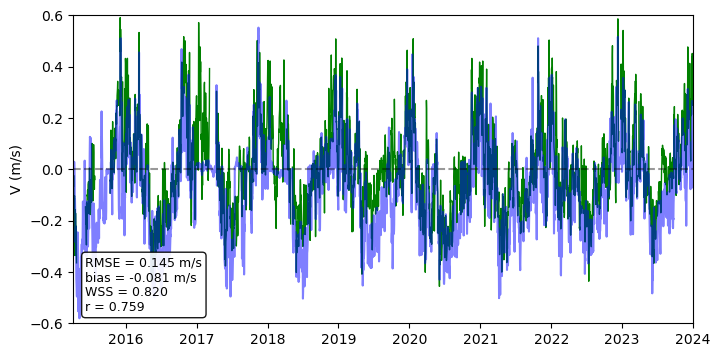

In [4]:
fig,ax = plt.subplots(1,1,figsize=(8,4))

ax.plot(df.datetime, df['northward_sea_water_velocity (m.s-1)'],'g',lw=1,label='Observations')
ax.plot(df.datetime, df['model_v'],'b',label='Model',alpha=0.5)
ax.set_ylabel('V (m/s)')
# plot the stats pannel
plot_panel(ax, df['northward_sea_water_velocity (m.s-1)'], df['model_v'], (-0.1,0.1), 'm/s')


ax.set_ylim([-0.6,0.6])
ax.plot([np.min(df.datetime),np.max(df.datetime)],[0,0],'k--',alpha=0.4)
ax.set_xlim([np.min(df.datetime),np.max(df.datetime)])
ax.plot([np.min(df.index),np.max(df.index)],[0,0],'k--',alpha=0.6)

# for j in range(0, len(season),2):
    # ax.fill_between(df.datetime, -5000, 85000, where=(df.datetime<season[j+1])&(df.datetime>=season[j]), color='whitesmoke')

In [5]:
window_size = 15  # 15 day running mean based on smoothing from Foreman et al., 2011 - Trends in upwelling and downwelling winds along the BritishColumbia shelf
df['smoothed_obs_v'] = df['northward_sea_water_velocity (m.s-1)'].rolling(window=window_size).mean()
df['smoothed_mod_v'] = df['model_v'].rolling(window=window_size).mean()

In [6]:
# spring and fall transition in observations:
obs_dates = np.array([dt.datetime(2015,3,4),dt.datetime(2015,10,6),
                      dt.datetime(2016,5,4),dt.datetime(2016,10,1),
                      dt.datetime(2017,5,4),dt.datetime(2017,10,22),
                      dt.datetime(2018,5,1),dt.datetime(2018,10,4),
                      dt.datetime(2019,4,28),dt.datetime(2019,9,20),
                      dt.datetime(2020,2,15),dt.datetime(2020,11,12),
                      dt.datetime(2021,3,27),dt.datetime(2021,10,1),
                      dt.datetime(2022,2,10),dt.datetime(2022,9,30)])

mod_dates = np.array([dt.datetime(2015,3,4),dt.datetime(2015,10,22),
                      dt.datetime(2016,4,5),dt.datetime(2016,10,1),
                      dt.datetime(2017,5,6),dt.datetime(2017,10,30),
                      dt.datetime(2018,5,1),dt.datetime(2018,10,25),
                      dt.datetime(2019,4,26),dt.datetime(2019,12,5),
                      dt.datetime(2020,2,12),dt.datetime(2020,11,12),
                      dt.datetime(2021,3,17),dt.datetime(2021,10,7),
                      dt.datetime(2022,1,25),dt.datetime(2022,10,5)])


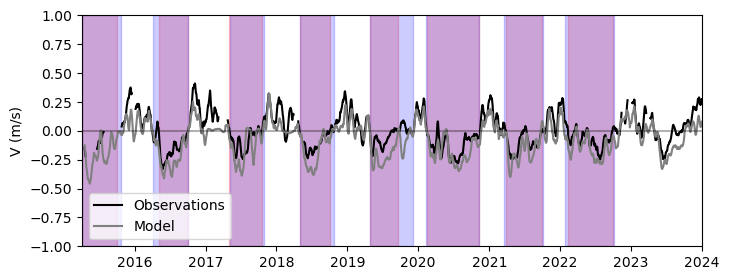

In [7]:
fig,ax = plt.subplots(1,1,figsize=(8,3))

ax.plot(df.datetime, df['smoothed_obs_v'],'k',label='Observations')
ax.plot(df.datetime, df['smoothed_mod_v'],'gray',label='Model')

ax.set_ylabel('V (m/s)')
ax.set_ylim([-1,1])
ax.plot([np.min(df.datetime),np.max(df.datetime)],[0,0],'k',alpha=0.3)
ax.set_xlim([np.min(df.datetime),np.max(df.datetime)])
# ax.plot([np.min(df.index),np.max(df.index)],[0,0],'k--',alpha=0.6)

ax.legend(loc="lower left")

for j in range(0, len(obs_dates),2):
    ax.fill_between(df.datetime, -1, 1, where=(df.datetime<obs_dates[j+1])&(df.datetime>=obs_dates[j]), color='r', alpha=0.2)
    ax.fill_between(df.datetime, -1, 1, where=(df.datetime<mod_dates[j+1])&(df.datetime>=mod_dates[j]), color='b', alpha=0.2)


### Same timeseries compared to Hourston and Thompson SOPO report

In [8]:
# from https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/41199248.pdf chapter 8
ht_dates = np.array([dt.datetime(2013,1,19),dt.datetime(2013,10,25),
                      dt.datetime(2014,3,4),dt.datetime(2014,9,15),
                      dt.datetime(2015,3,13),dt.datetime(2015,9,3),
                      dt.datetime(2016,3,21),dt.datetime(2016,9,13),
                      dt.datetime(2017,4,23),dt.datetime(2017,10,16),
                      dt.datetime(2018,2,11),dt.datetime(2018,9,9),
                      dt.datetime(2019,4,8),dt.datetime(2019,11,3),
                      dt.datetime(2020,2,4),dt.datetime(2020,10,15),
                      dt.datetime(2021,2,2),dt.datetime(2021,9,27),
                      dt.datetime(2022,6,10),dt.datetime(2022,10,23)])

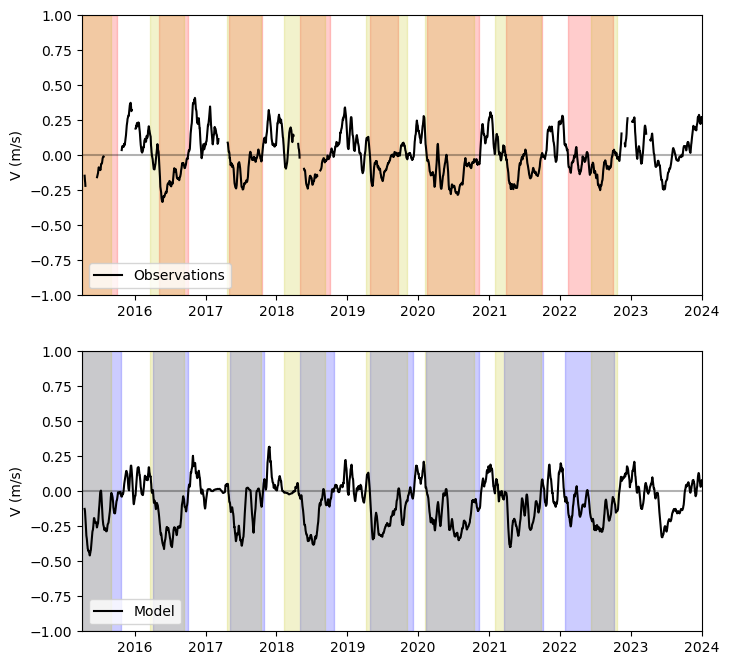

In [9]:
fig,ax = plt.subplots(2,1,figsize=(8,8))

ax[0].plot(df.datetime, df['smoothed_obs_v'],'k',label='Observations')
ax[1].plot(df.datetime, df['smoothed_mod_v'],'k',label='Model')

for axs in ax:
    axs.set_ylabel('V (m/s)')
    axs.set_ylim([-1,1])
    axs.plot([np.min(df.datetime),np.max(df.datetime)],[0,0],'k',alpha=0.3)
    axs.set_xlim([np.min(df.datetime),np.max(df.datetime)])
    axs.legend(loc="lower left")

for j in range(0, len(obs_dates),2):
    ax[0].fill_between(df.datetime, -1, 1, where=(df.datetime<obs_dates[j+1])&(df.datetime>=obs_dates[j]), color='r', alpha=0.2)
    ax[1].fill_between(df.datetime, -1, 1, where=(df.datetime<mod_dates[j+1])&(df.datetime>=mod_dates[j]), color='b', alpha=0.2)
for j in range(0, len(ht_dates),2):
    ax[0].fill_between(df.datetime, -1, 1, where=(df.datetime<ht_dates[j+1])&(df.datetime>=ht_dates[j]), color='y', alpha=0.2)
    ax[1].fill_between(df.datetime, -1, 1, where=(df.datetime<ht_dates[j+1])&(df.datetime>=ht_dates[j]), color='y', alpha=0.2)


what if i defined the "buffer" as the region of time where upwelling index in observations (from Hourston and Thomspson) dont overlap instead of a set number of days?

### And now looking at the CUTI index
available from https://mjacox.com/upwelling-indices/

In [10]:
cuti = xr.open_dataset('/data1/bbeutel/LO_user/CUTI_daily.nc')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


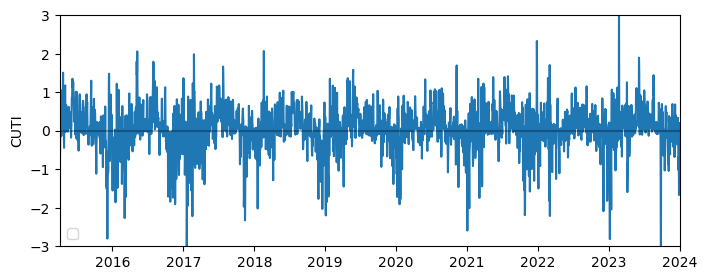

In [11]:
fig,ax = plt.subplots(1,1,figsize=(8,3))

ax.plot(cuti.time, cuti.CUTI[:,-1])

ax.set_ylabel('CUTI')
ax.set_ylim([-3,3])
ax.plot([np.datetime64(np.min(df.datetime)),np.datetime64(np.max(df.datetime))],[0,0],'k',alpha=0.3)
ax.set_xlim([np.datetime64(np.min(df.datetime)),np.datetime64(np.max(df.datetime))])
ax.legend(loc="lower left")

In [12]:
# actually lets do monthly
cuti = xr.open_dataset('/data1/bbeutel/LO_user/CUTI_monthly.nc')

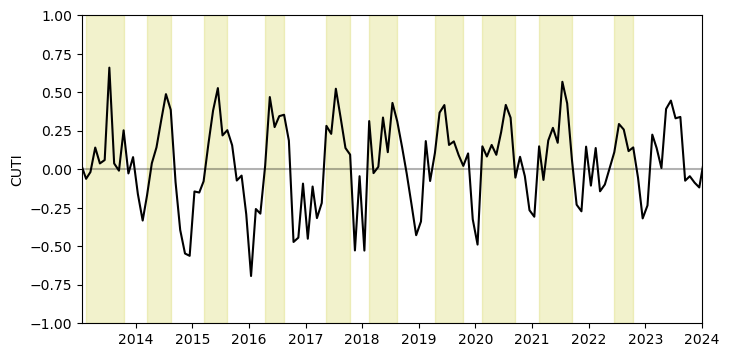

In [13]:
fig,ax = plt.subplots(1,1,figsize=(8,4))

ax.plot(cuti.time, cuti.CUTI[:,-1],'k')

ax.set_ylabel('CUTI')
ax.set_ylim([-1,1])
ax.plot([np.datetime64(np.min(ht_dates)),np.datetime64(np.max(df.datetime))],[0,0],'k',alpha=0.3)
ax.set_xlim([np.datetime64(np.min(ht_dates)),np.datetime64(np.max(df.datetime))])

for j in range(0, len(ht_dates),2):
    ax.fill_between(pd.to_datetime(cuti.time.values), -1, 1, where=(pd.to_datetime(cuti.time.values)<ht_dates[j+1])&(pd.to_datetime(cuti.time.values)>=ht_dates[j]), color='y', alpha=0.2)

agrees pretty well with Hourston and Thompson 2022

### Pick yur dates
ok so if we decide that where they (model and Hourston and Thompson) don't everlap IS the best call for buffer lets actually pick our dates!<br>

In [14]:
# in general (with the exeption of 2022) upwelling began later and ended later in the model 
up = np.array([dt.datetime(2015,3,13),dt.datetime(2015,9,3),
               dt.datetime(2016,4,5),dt.datetime(2016,9,13),
               dt.datetime(2017,5,6),dt.datetime(2017,10,16),
               dt.datetime(2018,5,1),dt.datetime(2018,9,9),
               dt.datetime(2019,4,26),dt.datetime(2019,11,3),
               dt.datetime(2020,2,12),dt.datetime(2020,10,15),
               dt.datetime(2021,3,17),dt.datetime(2021,9,27),
               dt.datetime(2022,6,10),dt.datetime(2022,10,5)])

down = np.array([dt.datetime(2015,10,22),dt.datetime(2016,3,12),
                 dt.datetime(2016,10,1),dt.datetime(2017,4,5),
                 dt.datetime(2017,10,30),dt.datetime(2018,2,11),
                 dt.datetime(2018,10,25),dt.datetime(2019,4,8),
                 dt.datetime(2019,12,5),dt.datetime(2020,2,4),
                 dt.datetime(2020,11,12),dt.datetime(2021,2,2),
                 dt.datetime(2021,10,7),dt.datetime(2022,1,25)])   

# must find obs for 2013 2014! - if not then use Hourston dates and 20 day buffer? (ie. into and out of dates by 10 days)

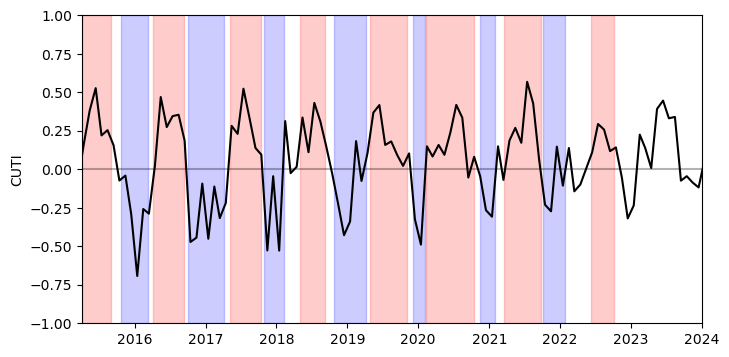

In [15]:
# compare to CUTI
fig,ax = plt.subplots(1,1,figsize=(8,4))

ax.plot(cuti.time, cuti.CUTI[:,-1],'k')

ax.set_ylabel('CUTI')
ax.set_ylim([-1,1])
ax.plot([np.datetime64(np.min(df.datetime)),np.datetime64(np.max(df.datetime))],[0,0],'k',alpha=0.3)
ax.set_xlim([np.datetime64(np.min(df.datetime)),np.datetime64(np.max(df.datetime))])

for j in range(0, len(up),2):
    ax.fill_between(df.datetime, -1, 1, where=(df.datetime<up[j+1])&(df.datetime>=up[j]), color='r', alpha=0.2)
for j in range(0, len(down),2):
    ax.fill_between(df.datetime, -1, 1, where=(df.datetime<down[j+1])&(df.datetime>=down[j]), color='b', alpha=0.2)

# ax.legend(loc="lower left")

In [16]:
# how long are each of the buffers?
up[1:-1]-down

array([datetime.timedelta(days=-49), datetime.timedelta(days=24),
       datetime.timedelta(days=-18), datetime.timedelta(days=31),
       datetime.timedelta(days=-14), datetime.timedelta(days=79),
       datetime.timedelta(days=-46), datetime.timedelta(days=18),
       datetime.timedelta(days=-32), datetime.timedelta(days=8),
       datetime.timedelta(days=-28), datetime.timedelta(days=43),
       datetime.timedelta(days=-10), datetime.timedelta(days=136)],
      dtype=object)

## can we get more years from a different mooring?
#### Hourston and Thomson use mooring A1 from the DFO, which i already have downloaded 

In [17]:
a1 = pd.read_pickle('/data1/bbeutel/LO_output/extract_cast/ios/-126.284163_48.681239999999995_cur.p')

#change it to daily
a1 = a1.set_index('datetime')
a1 = a1.resample('D',axis=0).mean()
a1['datetime'] = a1.index
a1['datetime'] = a1.datetime.dt.tz_localize(None)
index = pd.Index(range(len(a1)))
a1.set_index(index,inplace=True)

a1
# note that the intrument depth varies with time.. model cell changes accordingly so hopefully that OKAY for upwelling analysis

/tmp/ipykernel_161916/3793850695.py:5: FutureWarning: The 'axis' keyword in DataFrame.resample is deprecated and will be removed in a future version.
  a1 = a1.resample('D',axis=0).mean()


,longitude (degrees_east),latitude (degrees_north),instrument_depth (m),PRESPR01 (decibar),LCEWEL01 (m/s),LCNSEL01 (m/s),LRZASP01 (m/s),model_u,model_v,model_w,datetime
0,-126.284163,48.681240,64.2,66.509554,-0.040537,0.010483,-0.003821,-0.030805,0.103854,-0.000173,2012-12-31
1,-126.284163,48.681240,64.2,66.532921,-0.084754,0.052937,0.000625,-0.027154,0.101727,-0.000094,2013-01-01
2,-126.284163,48.681240,64.2,66.546450,-0.113279,-0.041454,-0.000717,-0.040478,0.088958,-0.000038,2013-01-02
3,-126.284163,48.681240,64.2,66.551992,-0.089562,-0.055850,-0.001667,-0.052803,0.015156,-0.000006,2013-01-03
4,-126.284163,48.681240,64.2,66.563012,-0.115933,0.021521,-0.009929,-0.047932,0.056577,-0.000063,2013-01-04
...,...,...,...,...,...,...,...,...,...,...,...
2399,-126.184330,48.548668,204.0,NaN,-0.009826,-0.021007,-0.008090,0.086205,-0.131597,-0.000104,2019-07-27
2400,-126.184330,48.548668,204.0,NaN,0.015271,-0.045924,0.003819,0.085184,-0.151474,-0.000461,2019-07-28
2401,-126.184330,48.548668,204.0,NaN,-0.071750,-0.043153,0.010910,0.097996,-0.161163,-0.000397,2019-07-29
2402,-126.184330,48.548668,204.0,NaN,-0.050181,-0.052167,0.004479,0.089534,-0.174777,-0.000615,2019-07-30


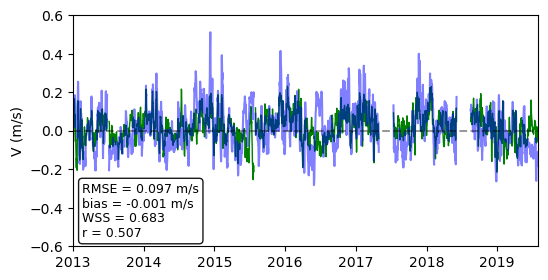

In [18]:
fig,ax = plt.subplots(1,1,figsize=(6,3))

ax.plot(a1.datetime, a1['LCNSEL01 (m/s)'],'g',lw=1,label='Observations')
ax.plot(a1.datetime, a1['model_v'],'b',label='Model',alpha=0.5)
ax.set_ylabel('V (m/s)')
# plot the stats pannel
plot_panel(ax, a1['LCNSEL01 (m/s)'], a1['model_v'], (-0.1,0.1), 'm/s')


ax.set_ylim([-0.6,0.6])
ax.plot([np.min(a1.datetime),np.max(a1.datetime)],[0,0],'k--',alpha=0.4)
ax.set_xlim([np.min(a1.datetime),np.max(a1.datetime)])
ax.plot([np.min(a1.index),np.max(a1.index)],[0,0],'k--',alpha=0.6)


In [19]:
# rotate both such that the wind magnitude toward 325 deg

# Define the direction in degrees (used same as Hourston and Thomson)
direction_degrees = 325

# Convert the direction to radians
direction_radians = np.deg2rad(direction_degrees)

# Calculate the wind magnitude towards the specified direction
# and smooth it
window_size= 15
a1['model_325'] = (a1['model_u'] * np.cos(direction_radians) + a1['model_v'] * np.sin(direction_radians)).rolling(window=window_size).mean()
a1['obs_325'] = (a1['LCEWEL01 (m/s)'] * np.cos(direction_radians) + a1['LCNSEL01 (m/s)'] * np.sin(direction_radians)).rolling(window=window_size).mean()

In [20]:
ht_dates = np.array([dt.datetime(2013,1,19),dt.datetime(2013,10,25),
                      dt.datetime(2014,3,4),dt.datetime(2014,9,15),
                      dt.datetime(2015,3,13),dt.datetime(2015,9,3),
                      dt.datetime(2016,3,21),dt.datetime(2016,9,13),
                      dt.datetime(2017,4,23),dt.datetime(2017,10,16),
                      dt.datetime(2018,2,11),dt.datetime(2018,9,9),
                      dt.datetime(2019,4,8),dt.datetime(2019,11,3),
                      dt.datetime(2020,2,4),dt.datetime(2020,10,15),
                      dt.datetime(2021,2,2),dt.datetime(2021,9,27),
                      dt.datetime(2022,6,10),dt.datetime(2022,10,23)])

down = np.array([dt.datetime(2013,11,3),dt.datetime(2014,3,4),
                 dt.datetime(2014,9,15),dt.datetime(2015,3,13),
                 dt.datetime(2015,10,22),dt.datetime(2016,3,12),
                 dt.datetime(2016,10,2),dt.datetime(2017,4,5),
                 dt.datetime(2017,11,1),dt.datetime(2018,2,11),
                 dt.datetime(2018,10,25),dt.datetime(2019,4,7),
                 dt.datetime(2019,12,5),dt.datetime(2020,1,29),
                 dt.datetime(2020,11,12),dt.datetime(2021,2,2),
                 dt.datetime(2021,10,12),dt.datetime(2022,1,25)])   

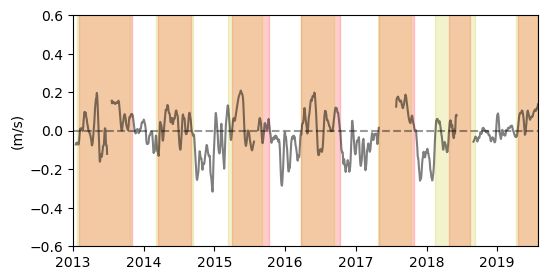

In [21]:
a1_up = np.array([dt.datetime(2013,2,1),dt.datetime(2013,11,3),
               dt.datetime(2014,3,13),dt.datetime(2014,9,3),
               dt.datetime(2015,4,1),dt.datetime(2015,10,13),
               dt.datetime(2016,3,25),dt.datetime(2016,10,13),
               dt.datetime(2017,5,2),dt.datetime(2017,10,29),
               dt.datetime(2018,4,25),dt.datetime(2018,8,15),
               dt.datetime(2019,4,16),dt.datetime(2019,11,3)])

fig,ax = plt.subplots(1,1,figsize=(6,3))

# ax.plot(a1.datetime, a1['obs_325'],'k',lw=1,label='Observations')
ax.plot(a1.datetime, a1['model_325'],'k',label='Model',alpha=0.5)
ax.set_ylabel('(m/s)')
# plot the stats pannel
# plot_panel(ax, a1['obs_325'], a1['model_325'], (-0.1,0.1), 'm/s')

ax.set_ylim([-0.6,0.6])
ax.plot([np.min(a1.datetime),np.max(a1.datetime)],[0,0],'k--',alpha=0.4)
ax.set_xlim([np.min(a1.datetime),np.max(a1.datetime)])
ax.plot([np.min(a1.index),np.max(a1.index)],[0,0],'k--',alpha=0.6)

for j in range(0, len(a1_up),2):
    ax.fill_between(a1.datetime, -1, 1, where=(a1.datetime<a1_up[j+1])&(a1.datetime>=a1_up[j]), color='r', alpha=0.2)
for j in range(0, len(ht_dates),2):
    ax.fill_between(a1.datetime, -1, 1, where=(a1.datetime<ht_dates[j+1])&(a1.datetime>=ht_dates[j]), color='y', alpha=0.2)

# Final upwelling and downwelling dates with min 20 d buffer between

In [22]:
up = np.array([dt.datetime(2013,2,1),dt.datetime(2013,10,19),
               dt.datetime(2014,3,19),dt.datetime(2014,8,30),
               dt.datetime(2015,4,2),dt.datetime(2015,9,3),
               dt.datetime(2016,4,5),dt.datetime(2016,9,12),
               dt.datetime(2017,5,6),dt.datetime(2017,10,12),
               dt.datetime(2018,5,1),dt.datetime(2018,9,9),
               dt.datetime(2019,4,27),dt.datetime(2019,11,3),
               dt.datetime(2020,2,18),dt.datetime(2020,10,15),
               dt.datetime(2021,3,17),dt.datetime(2021,9,22),
               dt.datetime(2022,6,10),dt.datetime(2022,10,5)])

down = np.array([dt.datetime(2013,11,8),dt.datetime(2014,2,27),
                 dt.datetime(2014,9,19),dt.datetime(2015,3,13),
                 dt.datetime(2015,10,22),dt.datetime(2016,3,12),
                 dt.datetime(2016,10,2),dt.datetime(2017,4,5),
                 dt.datetime(2017,11,1),dt.datetime(2018,2,11),
                 dt.datetime(2018,10,25),dt.datetime(2019,4,7),
                 dt.datetime(2019,12,5),dt.datetime(2020,1,29),
                 dt.datetime(2020,11,12),dt.datetime(2021,2,2),
                 dt.datetime(2021,10,12),dt.datetime(2022,1,25)])  

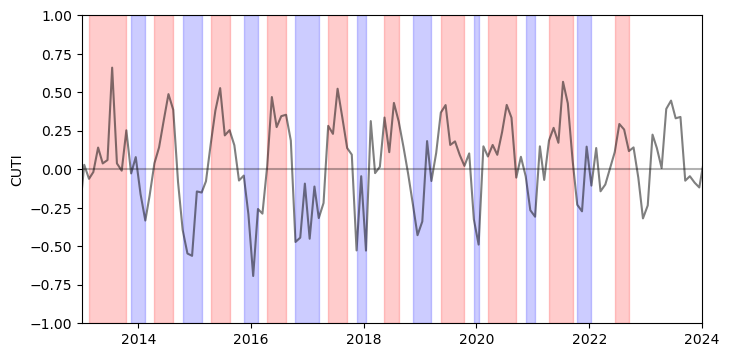

In [23]:
fig,ax = plt.subplots(1,1,figsize=(8,4))

ax.plot(cuti.time, cuti.CUTI[:,-1],'k',alpha=0.5, label="CUTI")

ax.set_ylabel('CUTI')
ax.set_ylim([-1,1])
ax.plot([np.datetime64(np.min(a1.datetime)),np.datetime64(np.max(df.datetime))],[0,0],'k',alpha=0.3)
ax.set_xlim([np.datetime64(np.min(a1.datetime)),np.datetime64(np.max(df.datetime))])

for j in range(0, len(up),2):
    ax.fill_between(pd.to_datetime(cuti.time.values), -1, 1, where=(pd.to_datetime(cuti.time.values)<up[j+1])&(pd.to_datetime(cuti.time.values)>=up[j]), color='r', alpha=0.2,zorder=0)
for j in range(0, len(down),2):
    ax.fill_between(pd.to_datetime(cuti.time.values), -1, 1, where=(pd.to_datetime(cuti.time.values)<down[j+1])&(pd.to_datetime(cuti.time.values)>=down[j]), color='b', alpha=0.2,zorder=0)

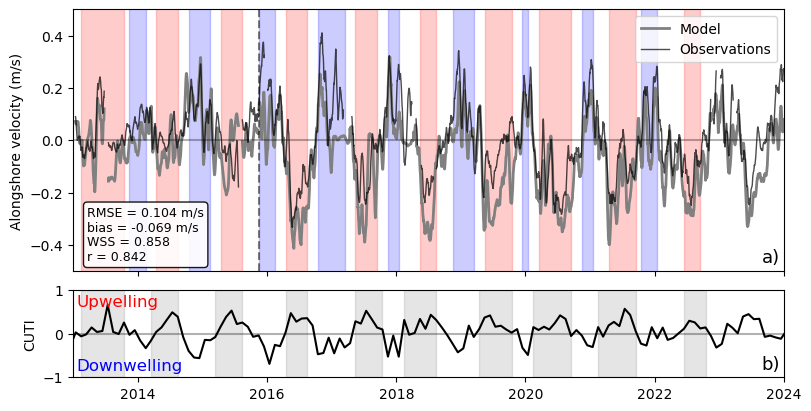

In [24]:
# update this figure once you have all the model output and this years SOPO

fig = plt.figure(constrained_layout=True, figsize=[8,4])
gs = GridSpec(4, 1, figure=fig)
ax = fig.add_subplot(gs[:3,0])
ax1 = fig.add_subplot(gs[3,0])

ax.set_ylabel('Alongshore velocity (m/s)')
ax.set_ylim([-0.5,0.5])
ax.plot(df.datetime[225:], df['smoothed_mod_v'][225:],'gray',lw=2,label='Model')
ax.plot(df.datetime[225:], df['smoothed_obs_v'][225:],'k',lw=1,label='Observations',alpha=0.7)

ax.plot(a1.datetime[:1050], a1['model_325'][:1050]*-1,'gray',lw=2)
ax.plot(a1.datetime[:1050], a1['obs_325'][:1050]*-1,'k',lw=1,alpha=0.7)

plot_panel(ax, np.append(a1['obs_325'][:1050]*-1,df['smoothed_obs_v'][225:]), np.append(a1['model_325'][:1050]*-1,df['smoothed_mod_v'][225:]), (-0.5,0.5), 'm/s')

ax.plot([np.datetime64(np.min(a1.datetime)),np.datetime64(np.max(df.datetime))],[0,0],'k',alpha=0.3)
ax.plot([df.datetime[225],df.datetime[225]],[-0.5,0.5],'k--',alpha=0.5)
ax.set_xlim([np.datetime64(np.min(a1.datetime)),np.datetime64(np.max(df.datetime))])
ax.set_xticklabels([])
ax.legend()

#cuti
ax1.plot(cuti.time, cuti.CUTI[:,-1],'k',label="CUTI")
ax1.set_ylabel('CUTI')
ax1.set_ylim([-1,1])
ax1.plot([np.datetime64(np.min(a1.datetime)),np.datetime64(np.max(df.datetime))],[0,0],'k',alpha=0.3)
ax1.set_xlim([np.datetime64(np.min(a1.datetime)),np.datetime64(np.max(df.datetime))])

# text
ax.text(.995, .02, 'a)', color='k', ha='right', va='bottom', transform=ax.transAxes, fontsize=13)
ax1.text(.995, .05, 'b)', color='k', ha='right', va='bottom', transform=ax1.transAxes, fontsize=13)
ax1.text(.005, .95, 'Upwelling', color='r', ha='left', va='top', transform=ax1.transAxes, fontsize=12)
ax1.text(.005, .05, 'Downwelling', color='b', ha='left', va='bottom', transform=ax1.transAxes, fontsize=12)




for j in range(0, len(up),2):
    ax.fill_between(pd.to_datetime(cuti.time.values), -1, 1, where=(pd.to_datetime(cuti.time.values)<up[j+1])&(pd.to_datetime(cuti.time.values)>=up[j]), color='r', alpha=0.2,zorder=0)
for j in range(0, len(down),2):
    ax.fill_between(pd.to_datetime(cuti.time.values), -1, 1, where=(pd.to_datetime(cuti.time.values)<down[j+1])&(pd.to_datetime(cuti.time.values)>=down[j]), color='b', alpha=0.2,zorder=0)
for j in range(0, len(ht_dates),2):
    ax1.fill_between(pd.to_datetime(cuti.time.values), -1, 1, where=(pd.to_datetime(cuti.time.values)<ht_dates[j+1])&(pd.to_datetime(cuti.time.values)>=ht_dates[j]), color='k', alpha=0.1)

In [25]:
# days between seasons
down-up[1:-1]

array([datetime.timedelta(days=20), datetime.timedelta(days=-20),
       datetime.timedelta(days=20), datetime.timedelta(days=-20),
       datetime.timedelta(days=49), datetime.timedelta(days=-24),
       datetime.timedelta(days=20), datetime.timedelta(days=-31),
       datetime.timedelta(days=20), datetime.timedelta(days=-79),
       datetime.timedelta(days=46), datetime.timedelta(days=-20),
       datetime.timedelta(days=32), datetime.timedelta(days=-20),
       datetime.timedelta(days=28), datetime.timedelta(days=-43),
       datetime.timedelta(days=20), datetime.timedelta(days=-136)],
      dtype=object)

In [26]:
# downwelling season length 
down[1:][::2]-down[:-1][::2]

array([datetime.timedelta(days=111), datetime.timedelta(days=175),
       datetime.timedelta(days=142), datetime.timedelta(days=185),
       datetime.timedelta(days=102), datetime.timedelta(days=164),
       datetime.timedelta(days=55), datetime.timedelta(days=82),
       datetime.timedelta(days=105)], dtype=object)

In [27]:
# upwelling season length 
up[1:][::2]-up[:-1][::2]

array([datetime.timedelta(days=260), datetime.timedelta(days=164),
       datetime.timedelta(days=154), datetime.timedelta(days=160),
       datetime.timedelta(days=159), datetime.timedelta(days=131),
       datetime.timedelta(days=190), datetime.timedelta(days=240),
       datetime.timedelta(days=189), datetime.timedelta(days=117)],
      dtype=object)